# CIFAR10 Training and quantization

Project inspired by this [kaggle competition](https://www.kaggle.com/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy#A-Simple-Keras-CNN-trained-on-CIFAR-10-dataset-with-over-88%-accuracy-(Without-Data-Augmentation). In this colab you will be driven through the training of a CNN for CIFAR10 classification task. The model is then exported for inference with tflite and quantized, prepared for the *GAPflow*.

### Used python modules

In [1]:
# from nntool.api import NNGraph
from model_v1 import *
from tqdm import tqdm
import tensorflow.keras as keras
import tensorflow_model_optimization as tfmot
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import tempfile
from PIL import Image

2022-11-13 16:50:12.857774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 16:50:12.968761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-13 16:50:12.968780: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-13 16:50:12.993657: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-13 16:50:13.465280: W tensorflow/stream_executor/platform/de

In [2]:
import tensorflow as tf
tf.__version__, tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-11-13 16:50:16.960419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 16:50:16.961587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-13 16:50:16.961611: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-13 16:50:16.961633: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cioflanc-HP-ENVY-x360-Convertible-13-ay0xxx): /proc/driver/nvidia/version does not exist


('2.10.0', False)

# Reading the CIFAR-10 dataset from Keras datasets

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, train_labels = train_images[:10000], train_labels[:10000]
test_images, test_labels = test_images[:1000], test_labels[:1000]

In [4]:
# Checking the number of rows (records) and columns (features)
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(10000, 32, 32, 3)
(10000, 1)
(1000, 32, 32, 3)
(1000, 1)


In [5]:
# Checking the number of unique classes 
print(np.unique(train_labels))
print(np.unique(test_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [6]:
# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

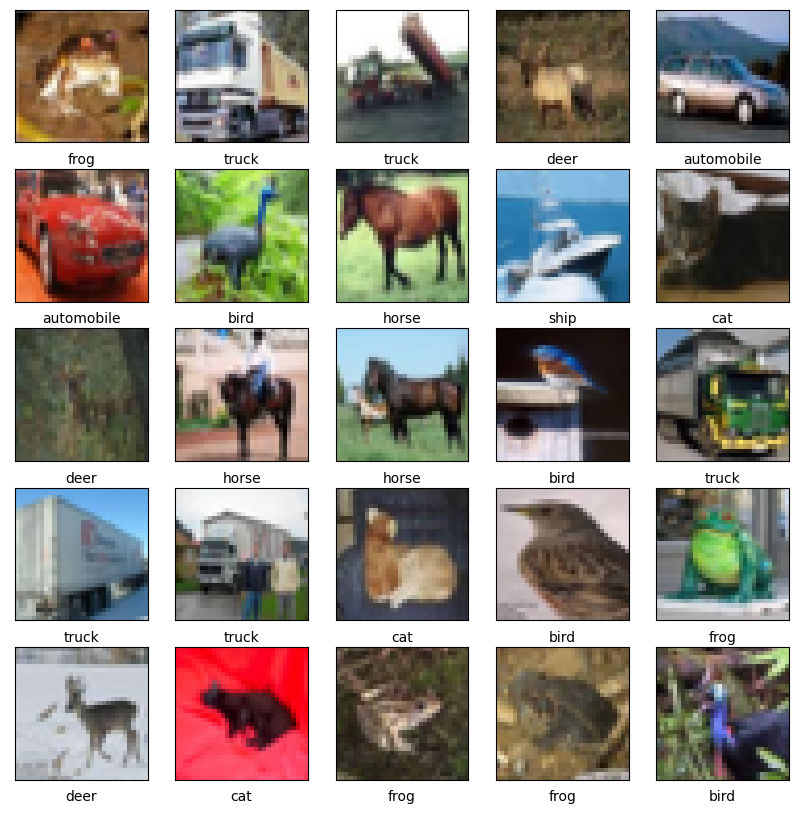

In [7]:
# Visualizing some of the images from the training dataset
plt.figure(figsize=[10,10])
for i in range (25):    # for first 25 images
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

plt.show()

# Data Preprocessing

Convert input [0:255] to [-1:1] float

Convert labels to one hot encoding

In [8]:
# Converting the pixels data to float type
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Standardizing (255 is the total number of pixels an image can have)
train_images = (train_images / 128) - 1.0
test_images = (test_images / 128) - 1.0

# One hot encoding the target class (labels)
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

## Model Design

In [9]:
# train all
for MODEL_VERSION in range(5,6):
    if MODEL_VERSION == 1:
        model = model_v1()
        model_name = "v1"
    elif MODEL_VERSION == 2:
        model = model_v2()
        model_name = "v2"
    elif MODEL_VERSION == 3:
        model = model_v3()
        model_name = "v3"
    elif MODEL_VERSION == 4:
        model = model_v4()
        model_name = "v4"
    elif MODEL_VERSION == 5:
        model = model_v5()
        model_name = "v5"
        
    model.summary()
    checkpoint_path = f"./checkpoints/saved_model_{model_name}/"
    model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    history = model.fit(train_images, train_labels, batch_size=64, epochs=50, # Add more epochs to get better results
                      validation_data=(test_images, test_labels))
    model.save(checkpoint_path)
    tflite_model_file = pathlib.Path(f"cifar10_model_{model_name}_fp32.tflite")
    # Converting a tf.Keras model to a TensorFlow Lite model.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the unquantized/float model:
    tflite_model_file.write_bytes(tflite_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        1216      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 32, 32, 16)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 16, 16, 16)       160       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 16)       64        
 hNormalization)                                                 
                                                        

Epoch 9/50
157/157 [==============================] - 7s 45ms/step - loss: 1.5662 - accuracy: 0.4227 - val_loss: 1.7367 - val_accuracy: 0.3720
Epoch 10/50
157/157 [==============================] - 7s 45ms/step - loss: 1.5274 - accuracy: 0.4358 - val_loss: 1.6411 - val_accuracy: 0.4220
Epoch 11/50
157/157 [==============================] - 7s 45ms/step - loss: 1.5034 - accuracy: 0.4414 - val_loss: 1.5357 - val_accuracy: 0.4600
Epoch 12/50
157/157 [==============================] - 7s 45ms/step - loss: 1.4528 - accuracy: 0.4609 - val_loss: 1.4456 - val_accuracy: 0.4880
Epoch 13/50
157/157 [==============================] - 7s 45ms/step - loss: 1.4314 - accuracy: 0.4721 - val_loss: 1.3785 - val_accuracy: 0.5090
Epoch 14/50
157/157 [==============================] - 7s 45ms/step - loss: 1.3990 - accuracy: 0.4895 - val_loss: 1.3330 - val_accuracy: 0.5160
Epoch 15/50
157/157 [==============================] - 7s 45ms/step - loss: 1.3874 - accuracy: 0.4914 - val_loss: 1.4915 - val_accuracy: 

INFO:tensorflow:Assets written to: ./checkpoints/saved_model_v5/assets


INFO:tensorflow:Assets written to: ./checkpoints/saved_model_v5/assets


INFO:tensorflow:Assets written to: /tmp/tmpmh7q3mwk/assets


INFO:tensorflow:Assets written to: /tmp/tmpmh7q3mwk/assets
2022-11-13 16:56:41.693996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-13 16:56:41.694032: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-13 16:56:41.694570: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmh7q3mwk
2022-11-13 16:56:41.702559: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-13 16:56:41.702597: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmh7q3mwk
2022-11-13 16:56:41.723145: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-13 16:56:41.732670: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-13 16:56:41.946794: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

In [10]:
MODEL_VERSION = 5

if MODEL_VERSION == 1:
    model = model_v1()
    model_name = "v1"
elif MODEL_VERSION == 2:
    model = model_v2()
    model_name = "v2"
elif MODEL_VERSION == 3:
    model = model_v3()
    model_name = "v3"
elif MODEL_VERSION == 4:
    model = model_v4()
    model_name = "v4"
elif MODEL_VERSION == 5:
    model = model_v5()
    model_name = "v5"

# Checking the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        1216      
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 re_lu_12 (ReLU)             (None, 32, 32, 16)        0         
                                                                 
 depthwise_conv2d_5 (Depthwi  (None, 16, 16, 16)       160       
 seConv2D)                                                       
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16, 16)       64        
 chNormalization)                                                
                                                      

# Compile and Train the model (or load the pretrained one)

In [11]:
#checkpoint_path = "gdrive/MyDrive/cifar10/saved_model/my_model"
print ({model_name})
checkpoint_path = f"./checkpoints/saved_model_{model_name}/"
train_again = False

if os.path.exists(checkpoint_path) and not train_again:
    model = tf.keras.models.load_model(checkpoint_path)
    history = None
else:
    model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    history = model.fit(train_images, train_labels, batch_size=64, epochs=2, # Add more epochs to get better results
                      validation_data=(test_images, test_labels))
    model.save(checkpoint_path)



{'v5'}


In [12]:
# Making the Predictions
pred = model.predict(test_images)
accuracy = 100 * np.sum(np.argmax(pred, 1) == np.argmax(test_labels, 1)) / len(test_labels)
print(f"Trained model Accuracy: {accuracy}%")

32/32 [==============================] - 0s 9ms/step
Trained model Accuracy: 64.7%


# Visualize training results

Only available if you have trained the model in this session

In [13]:
if history:
    # Loss curve
    plt.figure(figsize=[6,4])
    plt.plot(history.history['loss'], 'black', linewidth=2.0)
    plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
    plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.title('Loss Curves', fontsize=12)

In [14]:
if history:
    # Accuracy curve
    plt.figure(figsize=[6,4])
    plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
    plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.title('Accuracy Curves', fontsize=12)

# See the model at work

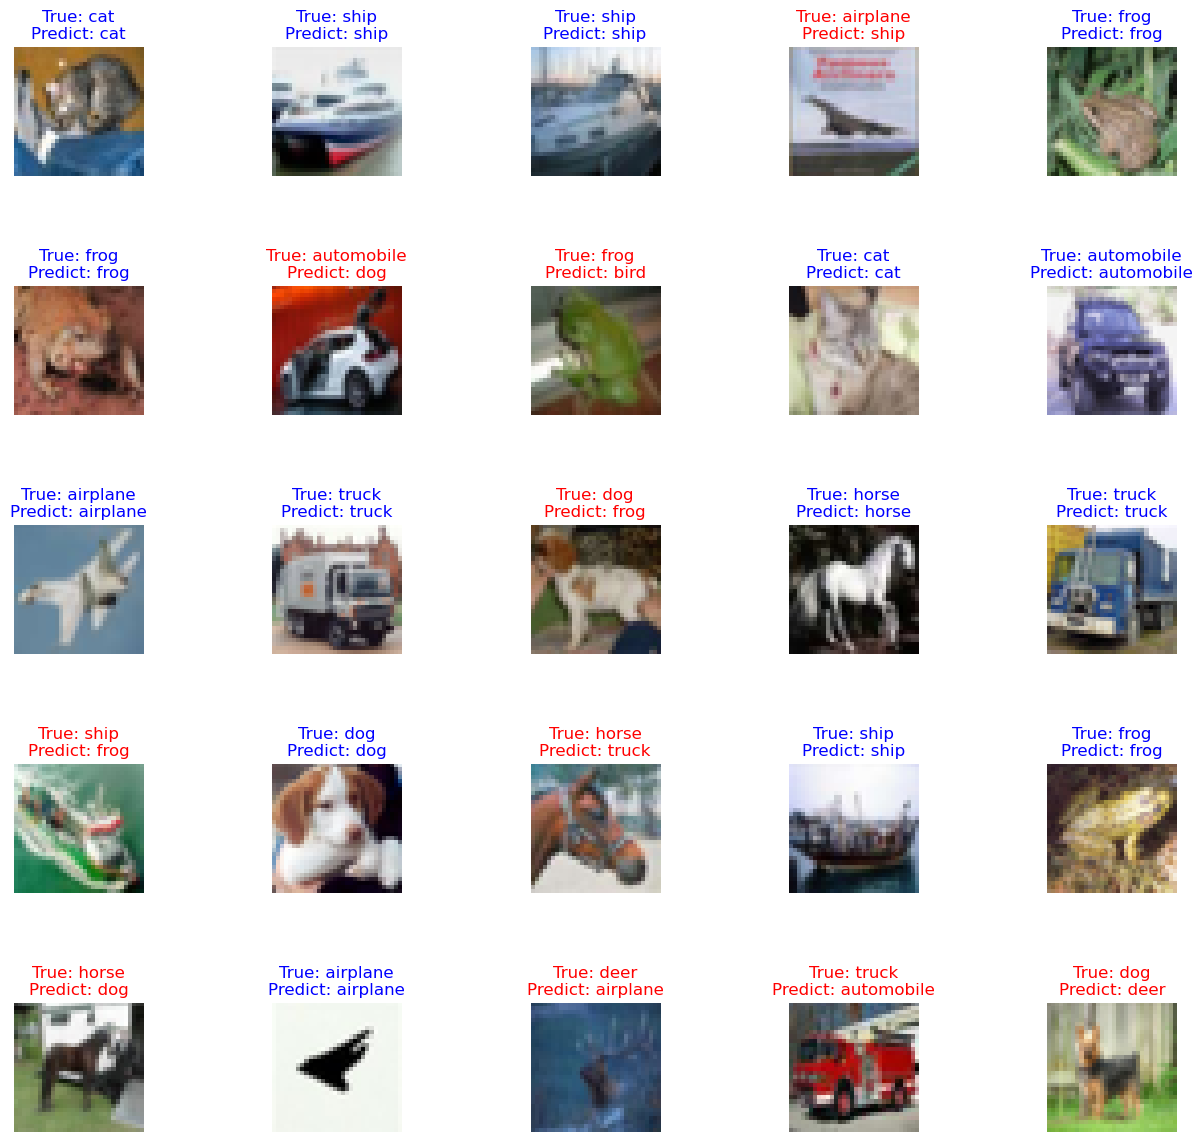

In [15]:
# Plotting the Actual vs. Predicted results
# Converting the predictions into label index 
pred_classes = np.argmax(pred, axis=1)

fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow((128*(test_images[i]+1)).astype(np.uint8))
    axes[i].set_title(f"True: {class_names[np.argmax(test_labels[i])]}\nPredict: {class_names[pred_classes[i]]}", color="r" if class_names[np.argmax(test_labels[i])]!=class_names[pred_classes[i]] else "b")
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)
    img = Image.fromarray(np.uint8(128*(test_images[i]+1)))
    img.save(f"samples/cifar_test_{i}_{np.argmax(test_labels[i])}.ppm")


# Convert to tflite

In [16]:
# Helper function to run inference on a TFLite model
def test_tflite_model(tflite_file, test_images, test_labels):
    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_images),), dtype=int)
    for i, (test_image, test_label) in enumerate(tqdm(zip(test_images, test_labels), total=len(test_labels))):
        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax()

    test_labels_not_one_hot = np.argmax(test_labels, 1)
    accuracy = (np.sum(test_labels_not_one_hot == predictions) * 100) / len(test_images)
    return accuracy

In [17]:
tflite_model_file = pathlib.Path(f"cifar10_model_{model_name}_fp32.tflite")

In [18]:
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the unquantized/float model:
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpwsvc0d0x/assets


INFO:tensorflow:Assets written to: /tmp/tmpwsvc0d0x/assets
2022-11-13 17:02:41.215386: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-13 17:02:41.215413: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-13 17:02:41.215559: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwsvc0d0x
2022-11-13 17:02:41.222768: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-13 17:02:41.222807: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwsvc0d0x
2022-11-13 17:02:41.248152: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-13 17:02:41.350965: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwsvc0d0x
2022-11-13 17:02:41.396452: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

1202096

In [19]:
fp32_accuracy = test_tflite_model(tflite_model_file, test_images, test_labels)
print(f"\nFloat model accuracy: {fp32_accuracy}")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
100%|██████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6167.91it/s]


Float model accuracy: 64.7


## Quantize to INT8 using PTQ

We use post-training (integer) quantization (PTQ) to quantize the model (https://www.tensorflow.org/lite/performance/post_training_integer_quant).

Weights are quantized directly from their values (they are constants), activations on the other hand depend on the input data. Hence we need to provide a calibration dataset to the quantizer so that it can run inference on it and collect the statistics of each layer in order to quantize the values in those ranges, i.e. Layer1 -> [-3.0, 6.0], Layer2 -> [-1.0, 2.5], ...

As calibration dataset we need representative data of our use case. They cannot be the testing set, we are "learning" the statistics so using test dataset would be cheating. A subset of the training is tipycally used.

In [20]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()




INFO:tensorflow:Assets written to: /tmp/tmpiqmsds1p/assets


INFO:tensorflow:Assets written to: /tmp/tmpiqmsds1p/assets
/home/cioflanc/miniconda3/envs/gapcifar10/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-11-13 17:02:51.682754: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-13 17:02:51.682780: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-13 17:02:51.682938: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiqmsds1p
2022-11-13 17:02:51.694511: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-13 17:02:51.694548: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiqmsds1p
2022-11-13 17:02:51.725910: I tensorflow/cc/

In [21]:
# Declare the saving path. Make sure that the directory exists.
tflite_quant_model_file = pathlib.Path(f"model/cifar10_{model_name}_uint8.tflite")

In [22]:
# Save the unquantized/float model:
tflite_quant_model_file.write_bytes(tflite_model_quant)

329888

In [23]:
quant_accuracy = test_tflite_model(tflite_quant_model_file, test_images, test_labels)
print(f"Quantized model accuracy: {quant_accuracy}")

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3171.64it/s]

Quantized model accuracy: 64.3


## Quantize to INT8 using QAT

After performing post-training quantization, we might notice an accuracy drop between the FP32 and INT8 networks. As the weights are kept constant during PTQ and the activations' range is analysed only with respect to the input (calibration) data, such a quantization strategy, albeit quick, can render a model inefficient.

Quantization-aware training (QAT) updates the model's weights whilst reducing the bitwidth. A comprehensive guide on TensorFlow-based QAT is available [here](https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide).

In [24]:
# Clone the trained TensorFlow model

quantize_model = tfmot.quantization.keras.quantize_model
tf_model_qat = quantize_model(model)

# We need to compile again the model
tf_model_qat.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

tf_model_qat.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 32, 32, 3)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 32, 32, 16)       1249      
 erV2)                                                           
                                                                 
 quant_batch_normalization (  (None, 32, 32, 16)       65        
 QuantizeWrapperV2)                                              
                                                                 
 quant_re_lu (QuantizeWrappe  (None, 32, 32, 16)       3         
 rV2)                                                            
                                                                 
 quant_depthwise_conv2d (Qua  (None, 16, 16, 16)       1

 pperV2)                                                         
                                                                 
 quant_dropout_3 (QuantizeWr  (None, 128)              1         
 apperV2)                                                        
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               1295      
 perV2)                                                          
                                                                 
Total params: 302,001
Trainable params: 299,418
Non-trainable params: 2,583
_________________________________________________________________


In [28]:
# Finetune the fake-quantized model on a subset of the training data

checkpoint_path = f"./checkpoints/saved_model_qat_{model_name}/"

history = tf_model_qat.fit(train_images, train_labels, batch_size=64, epochs=1, # Add more epochs to get better results
                  validation_data=(test_images, test_labels))
tf_model_qat.save(checkpoint_path)



157/157 [==============================] - 9s 60ms/step - loss: 0.8138 - accuracy: 0.7113 - val_loss: 0.9073 - val_accuracy: 0.6830


INFO:tensorflow:Assets written to: ./checkpoints/saved_model_qat_v5/assets


INFO:tensorflow:Assets written to: ./checkpoints/saved_model_qat_v5/assets


In [29]:
# Evaluate the QAT model

pred = tf_model_qat.predict(test_images)
accuracy = 100 * np.sum(np.argmax(pred, 1) == np.argmax(test_labels, 1)) / len(test_labels)
print(f"Trained model Accuracy: {accuracy}%")

32/32 [==============================] - 0s 11ms/step
Trained model Accuracy: 68.3%


In [30]:
# Quantize and save the model

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter_qat = tf.lite.TFLiteConverter.from_keras_model(tf_model_qat)
converter_qat.optimizations = [tf.lite.Optimize.DEFAULT]
converter_qat.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter_qat.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter_qat.inference_input_type = tf.uint8
converter_qat.inference_output_type = tf.uint8

tflite_model_qat_quant = converter_qat.convert()

tflite_quant_qat_model_file = pathlib.Path(f"model/cifar10_qat_{model_name}_uint8.tflite")
tflite_quant_qat_model_file.write_bytes(tflite_model_qat_quant)

INFO:tensorflow:Assets written to: /tmp/tmpj11sofnn/assets


INFO:tensorflow:Assets written to: /tmp/tmpj11sofnn/assets
/home/cioflanc/miniconda3/envs/gapcifar10/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-11-13 17:07:26.167136: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-13 17:07:26.167168: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-13 17:07:26.167321: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj11sofnn
2022-11-13 17:07:26.192685: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-13 17:07:26.192725: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpj11sofnn
2022-11-13 17:07:26.265754: I tensorflow/cc/

331888

In [31]:
# Evaluate the QAT model
quant_qat_accuracy = test_tflite_model(tflite_quant_qat_model_file, test_images, test_labels)
print(f"Quantized model accuracy: {quant_qat_accuracy}")

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3107.15it/s]

Quantized model accuracy: 68.6


Did the accuracy increase compared to the PTQ solution? By how much?
<br>
Is this due to the benefits of QAT? How can you tell?

# NNTool Test

In [ ]:
def nntool_inference(graph, test_images, test_labels):
    predictions = np.zeros((len(test_images),), dtype=int)
    for i, (test_image, test_label) in enumerate(tqdm(zip(test_images, test_labels), total=len(test_labels))):
        output = graph.execute([test_image], dequantize=True)
        predictions[i] = output[-1][0].argmax()

    test_labels_not_one_hot = np.argmax(test_labels, 1)
    accuracy = (np.sum(test_labels_not_one_hot == predictions) * 100) / len(test_images)
    return accuracy

In [ ]:
TFLITE_PATH = "model/cifar10_model_uint8.tflite"
NE16 = False
G = NNGraph.load_graph(TFLITE_PATH, load_quantization=True)
G.quantize(None, graph_options={"use_ne16": NE16, "hwc": True})
G.adjust_order()
G.fusions("scaled_match_group")
#G.draw(quant_labels=True, fusions=True, view=False, filepath="nntool_graph")

In [ ]:
nntool_quant_accuracy = nntool_inference(G, test_images[:1000], test_labels[:1000])
print(f"Quantized model accuracy: {nntool_quant_accuracy}")

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(TFLITE_PATH))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

test_image = test_images[0]
# Check if the input type is quantized, then rescale input data to uint8
if input_details['dtype'] == np.uint8:
    input_scale, input_zero_point = input_details["quantization"]
    test_image = test_image / input_scale + input_zero_point
test_image = np.expand_dims(test_images[0], axis=0).astype(input_details["dtype"])

interpreter.set_tensor(input_details["index"], test_image)
interpreter.invoke()
output_scale, output_zero_point = output_details["quantization"]
tflite_output = (interpreter.get_tensor(output_details["index"])[0] - output_zero_point) * output_scale

nntool_output = G.execute([test_images[0]], dequantize=True)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(nntool_output[-1][0])
plt.plot(tflite_output)

# Quantize in NNTool

In [ ]:
TFLITE_PATH = "model/cifar10_model_uint8.tflite"
NE16 = True
G = NNGraph.load_graph(TFLITE_PATH, load_quantization=True)

stats = G.collect_statistics([np.array(data) for data in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100)])
G.quantize(stats, graph_options={"use_ne16": NE16, "hwc": True})
G.adjust_order()
G.fusions("scaled_match_group")


In [ ]:
nntool_quant_accuracy = nntool_inference(G, test_images[:1000], test_labels[:1000])
print(f"Quantized model accuracy: {nntool_quant_accuracy}")

In [ ]:
print(G.qshow())